In [1]:
from keras.preprocessing.image import img_to_array, load_img
from PIL import Image
import random
import numpy as np
import glob
import os

def loadImage(img_path, outputs = 0, number = 0):
    #img = load_img(img_path, target_size=(28, 28)) 
    #img = Image.open(img_path, 'r')
    #pix = np.invert(Image.open(img_path).convert('L')).ravel()
    pix = np.asarray(Image.open(img_path).convert('L'))
    pix = pix * (1 / 255)
    pix = pix.reshape(784)
    #pix = pix * (0.99 / 255) + 0.01
    #pix = list(img.getdata())
    #pix = np.dot(pix, 1/255)
    if outputs != 0:
        for i in outputs:
            if i == number:
                pix = np.append(pix, 1)
            else:
                pix = np.append(pix, 0)
    return pix

def load_training_dataset(outputs, data_nb = 0):
    dataset = []
    path = 'Training data/'
    
    filenames = []
    for o in outputs:
        for filename in glob.glob(path + str(o) + '/*.png'): 
            base = os.path.basename(filename)
            filenames.append([str(o) + '/' + base, o])
    
    random.shuffle(filenames)
    if data_nb != 0:
        filenames = filenames[:data_nb]
        
    for file in filenames:
        dataset.append(loadImage(path + file[0], outputs, file[1]))
    return dataset

def load_dataset(path):
    dataset = []
    filenames = []
    for filename in glob.glob(path + '/*.png'): 
        dataset.append(loadImage(filename))
        base = os.path.splitext(os.path.basename(filename))[0]
        filenames.append(base)
     
    return len(dataset), filenames

def load_testing_dataset(path):
    dataset = []
    filenames = []
    
    for filename in glob.glob(path + '/*.png'): 
        dataset.append(loadImage(filename))
        base = os.path.splitext(os.path.basename(filename))[0]
        filenames.append(base)
        
    return dataset, filenames

Using TensorFlow backend.


In [9]:
import numpy as np
import math
import matplotlib.pyplot as plt
from decimal import *

getcontext().prec = 100

def sigmoid(x):
    """
    if x > 100 or x < -100:
        x /= 1000
    elif x > 10 or x < -10:
        x/= 100
    elif x > 7 or x < -7:
        x /= 10
    """
    return Decimal(1 / (1 + Decimal(math.exp(-x))))


# Forward propagate input to a network output
def forward_propagate(network, row):
    inputs = row
    vect_sigmoid = np.vectorize(sigmoid)
    for i in range(len(network)):
        layer = network[i]
        new_inputs = []
        
        inputs = np.asarray([Decimal(s) for s in inputs])
        act_sum = np.dot(layer[1]['w'], inputs)
        layer[0]['a'] = vect_sigmoid(act_sum.astype(Decimal))
            
        layer[0]['a'] = np.asarray([Decimal(s) for s in layer[0]['a']])
        
        new_inputs.append(layer[0]['a'])
        inputs = new_inputs[0]
    return inputs

# Update network weights with error
def update_weights(network, data, l_rate):
    delta = list()
    for i in range(len(network)):
        layer = network[i]
        #deltas = list()
        
        layer[3]['e'] = np.asarray([Decimal(i) for i in layer[3]['e']])
        for neuron in range(len(layer[1]['w'])):
            #n = list()
            for b_neuron in range(len(layer[1]['w'][neuron])):
                if i != 0:
                    delta = Decimal(l_rate) * layer[3]['e'][neuron] * network[i - 1][0]['a'][b_neuron]
                    #n.append(l_rate * layer[3]['e'][neuron] * network[i - 1][0]['a'][b_neuron])
                else:
                    delta = Decimal(l_rate) * layer[3]['e'][neuron] * data[b_neuron]
                    #n.append(l_rate * layer[3]['e'][neuron] * data[b_neuron])
                layer[1]['w'][neuron][b_neuron] = layer[1]['w'][neuron][b_neuron] + delta
                

        
            
# Backpropagate error and store in neurons
def backward_propagate_error(network, expected):
    for i in reversed(range(len(network))):
        layer = network[i]
        errors = list()
        
        # case where it is not the output layer
        if i != len(network)-1:
            o_errors = network[i + 1][3]['e']
            o_weights = network[i + 1][1]['w']
            errors = np.dot(
                np.dot(np.transpose(o_weights), o_errors),
                np.dot(layer[0]['a'], Decimal(1) - layer[0]['a']))
            layer[3]['e'] = errors
        else:
            errors = np.dot(np.transpose(expected) - layer[0]['a'], np.dot(layer[0]['a'], (1 - layer[0]['a'])))
            layer[3]['e']  = errors
            
            
def update_line(hl, new_data, iter):
    hl.set_xdata(np.append(hl.get_xdata(), iter))
    hl.set_ydata(np.append(hl.get_ydata(), new_data))
    plt.draw()
    
# Train a network for a fixed number of epochs
def train_network(network, train, l_rate, nb_outputs, nb_iter):
    err_plot, = plt.plot([], [])
    plt.ylabel('error')
    axes = plt.gca()
    axes.set_xlim([0, nb_iter])
    axes.set_ylim([0, 1])
    #axes.set_ylim([0, len(train) * 0.4])
    iter = 0
    plt.draw()
    min_err = 2
    for epoch in range(nb_iter):
        error = 0
        for data in train:
            new_data = data[: len(data) - nb_outputs] 
            outputs = forward_propagate(network, new_data)
            # get last elements from data row (contains expected outputs)
            expected = data[-nb_outputs:]
            #print(outputs)
            # expected = [0 for i in range(n_outputs - 1)]
            # expected[row[-1]] = 1
            #cost_function = 0.5 * sum([(expected[i]-outputs[i])**2 for i in range(len(expected))])
            error += error_function(expected, outputs)
            backward_propagate_error(network, expected)
            update_weights(network, data, l_rate)
        
        final_err = Decimal(error / len(train))
        print('>epoch=%d, lrate=%.3f, error=%.3f' % (epoch, l_rate, final_err))
        update_line(err_plot, final_err, epoch)
        if error < min_err:
            min_err = final_err
        if error < 0.0001:
            print('error : ' + str(final_err))
            return network
    print('error     : ' + str(final_err))
    print('min error : ' + str(min_err))
    return network
    #print(network)
        # print('>epoch=%d, lrate=%.3f, error=%.3f' % (epoch, l_rate, sum_error))
    #print(sum_error)
    
def error_function(expected, outputs):
    return Decimal(1/len(outputs)) * Decimal(sum([(expected[i]-outputs[i])**2 for i in range(len(expected))]))

def initialize_network(nb_inputs, nb_hidden, nb_hidden_layers, nb_outputs):
    network = list()
    w = []
    
    # additionnal hidden layers
    for i in range(nb_hidden_layers):
        neurons = [{ 'neurons': nb_hidden[i]}]
        if i == 0:
            w.append(np.random.rand(nb_hidden[i], nb_inputs))
        else:
            w.append(np.random.rand(nb_hidden[i], nb_hidden[i - 1]))
        network.append(neurons)
    print(w)
    # output layer
    neurons = [{ 'neurons': nb_outputs}]
    w.append(np.random.rand(nb_outputs, nb_hidden[nb_hidden_layers - 1]))
    #w.append([[0.2, -0.1], [0.7, -1], [0.4, 0.4]])
    network.append(neurons)
    for layer in network:
              
        w[0] = [[Decimal(i) for i in j] for j in w[0]]
        wTmp = {'w': w[0]}
        layer.append(wTmp)
        w.pop(0)
        
        aTmp = { 'a': np.random.rand(layer[0]['neurons'])}
        layer.append(aTmp)
        
        eTmp = { 'e': np.random.rand(layer[0]['neurons'])}
        layer.append(eTmp)
    return network
  
    
# data_type => either 'img' or 'xor'
# data_nb => number of data rows (entries)
# nb_iter => number of iterations ot get to result
# outputs => list of outputs (from 0 to 9 for img), not necessary for XOR
# nb_hidden layer => number of hidden layers, 1 by default
# nb_hidden => number of hidden neurons on each hidden layer ( 2 by default )

# load input : load_testing_dataset(data_nb)
def test(network, dataset, data_nb, categories = [], filenames = []):
    outputs = list()
    if data_nb == 1:
        outputs = forward_propagate(network, dataset)
    else:
        for data in dataset:
            outputs.append(forward_propagate(network, data))
   
    if categories != []:
        for m in range(len(outputs)):
            val = [i for i in np.where(outputs[m] == np.amax(outputs[m]))]
            outputs[m] = categories[val[0][0]]
    
    results = outputs
    
    if filenames == []:
        return results
    else :
        results = np.around(outputs).astype(int)
        final = list()

        for i in range(len(results)):
            final.append({ filenames[i] : results[i]})
            

        with open('outputs.txt', 'w') as f:
            for item in final:
                f.write("%s\n" % str(item).replace('{', '').replace('}', '').replace("'", '').replace(':', ''))
        return final
    

def train(data_type, data_nb, nb_iter = 0, outputs = [], nb_hidden = [16], nb_hidden_layer = 1):

    nb_outputs = 0
    nb_inputs = 0
    #for images
    if data_type == 'img':
        nb_inputs = 28 * 28
        nb_outputs = len(outputs)
        x = np.array(load_training_dataset(outputs, data_nb), dtype=np.dtype(Decimal))
        x = [[ Decimal(i) for i in j] for j in x]
    elif data_type == 'xor':
        nb_outputs = 3
        nb_inputs = 2
        x = [[1, 0, 1, 1, 1], [1, 1, 0, 1, 0], [0, 0, 1, 0, 0], [0, 1, 0, 0, 1]]
    else:
        return 'Wrong datatype (should be img or xor)'


    network = initialize_network(nb_inputs, nb_hidden, nb_hidden_layer, nb_outputs)
    return train_network(network, x, 1, nb_outputs, nb_iter)

[array([[0.68350245, 0.32217859, 0.58602637, ..., 0.99536906, 0.70828695,
        0.26331423],
       [0.05308636, 0.23534346, 0.169074  , ..., 0.35255862, 0.17297659,
        0.71988545],
       [0.55183884, 0.69289787, 0.1960446 , ..., 0.16444306, 0.69015312,
        0.91613269],
       ...,
       [0.87708968, 0.63187046, 0.54260807, ..., 0.94186732, 0.63434147,
        0.63586004],
       [0.69979596, 0.63975135, 0.2442546 , ..., 0.53465886, 0.99369189,
        0.81407122],
       [0.45286962, 0.34391781, 0.70641055, ..., 0.19460287, 0.36703393,
        0.92371061]])]


KeyboardInterrupt: 

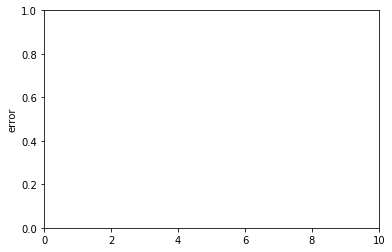

In [10]:

network = train('img', 1000, 10, [0,1,3], [16], 1)
dataset, filenames = load_testing_dataset('Testing data')
test(network, dataset, 9, [0,1,3], filenames)

In [24]:
vect = np.random.rand(3, 10) / 1000
vect

array([[2.70029628e-04, 5.23588875e-04, 6.47849363e-04, 6.53988678e-04,
        8.41924020e-04, 3.72420468e-04, 7.40430679e-04, 1.87649536e-04,
        6.35230391e-06, 1.81401073e-04],
       [8.93851747e-04, 9.23852335e-04, 3.47865721e-04, 3.01907879e-04,
        1.56744583e-04, 1.14722881e-04, 8.81341121e-04, 5.36053311e-04,
        7.19867209e-04, 8.63572225e-04],
       [4.22466681e-05, 6.04778609e-04, 8.45425303e-04, 3.74016276e-05,
        3.42948399e-05, 4.92980882e-04, 8.87785303e-04, 9.58301802e-04,
        9.96164898e-04, 1.66079863e-04]])